In [176]:
# import geopandas as gpd
import numpy as np
import pandas as pd
import copy
import os
import numpy as np
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import classification_report
#Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score


#classifiers End


import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./data/nndb_flat.csv")

In [3]:
data.head()

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353.0,21.40,28.74,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371.0,23.24,29.68,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [9]:
data.notnull()
data = data.drop(columns=['CommonName','MfgName','ScientificName'])

In [10]:
data.head()

,ID,FoodGroup,ShortDescrip,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",876.0,0.28,99.48,0.00,0.00,0.0,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",353.0,21.40,28.74,2.34,0.50,0.0,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",371.0,23.24,29.68,2.79,0.51,0.0,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [25]:
descrip = np.array(data['Descrip'])
words = ""
for i in descrip:
    words += i.lower()+','
differentwords = (words.split(','))

In [26]:
count = 0
for i in differentwords:
    if('pizza' in i):
        count+=1


In [28]:
count

97

In [29]:
len(set(differentwords))

5952

In [30]:
groups = np.array(data['FoodGroup'])
len(set(groups))

25

In [31]:
set(differentwords)

{'',
 ' mesquite flavor',
 ' country-style ribs',
 ' 2 1/2 minute cook time',
 '  85% lean / 15% fat',
 ' gripz',
 ' tagalongs cookies',
 ' canadian',
 ' easy open',
 ' mini chocolate chip cookies',
 ' chanterelle',
 ' veal',
 ' peanut butter sandwich',
 ' arroz con frijoles negros (rice and black beans)',
 ' shoulder breast',
 ' with cheese',
 ' sugar substitute',
 ' lemon',
 'butterbur',
 ' garden vegetable',
 ' unflavored',
 ' original 7-grain crackers',
 ' pregestimil',
 ' (bay and sea)',
 ' applesauce and pineapple',
 ' parmesan',
 ' top loin petite roast/filet',
 ' keebler chocolate graham selects',
 ' 3.7% milkfat',
 'morningstar farms grillers quarter pound veggie burger',
 'meat drippings (lard',
 ' cream of onion soup',
 ' arm pot roast',
 ' sandwich-type with peanut butter filling',
 ' rice',
 ' with cheese and egg',
 ' enfacare lipil',
 ' (boston butt)',
 ' baby ruth bar',
 ' hamburger or hotdog',
 ' jalapenos nacho sliced peppers',
 ' sweet potatoes strained',
 ' sugar fre

In [32]:
set(groups)

{'American Indian/Alaska Native Foods',
 'Baby Foods',
 'Baked Products',
 'Beef Products',
 'Beverages',
 'Breakfast Cereals',
 'Cereal Grains and Pasta',
 'Dairy and Egg Products',
 'Fast Foods',
 'Fats and Oils',
 'Finfish and Shellfish Products',
 'Fruits and Fruit Juices',
 'Lamb, Veal, and Game Products',
 'Legumes and Legume Products',
 'Meals, Entrees, and Side Dishes',
 'Nut and Seed Products',
 'Pork Products',
 'Poultry Products',
 'Restaurant Foods',
 'Sausages and Luncheon Meats',
 'Snacks',
 'Soups, Sauces, and Gravies',
 'Spices and Herbs',
 'Sweets',
 'Vegetables and Vegetable Products'}

In [37]:
nonveg = [
 'American Indian/Alaska Native Foods',
 'Beef Products',
 'Dairy and Egg Products',
 'Finfish and Shellfish Products',
 'Lamb, Veal, and Game Products',
 'Pork Products',
 'Poultry Products',
 'Sausages and Luncheon Meats',]
remove = ['Restaurant Foods','Meals, Entrees, and Side Dishes', 'Fast Foods', 'Baked Products',]

In [35]:
len(remove)

4

In [45]:
newlabels = []
index = []
j = 0
for i in groups:
    if(i in nonveg):
        newlabels.append('Non-Veg')
    elif(i in remove):
        newlabels.append('Remove')
        index.append(j)
    else:
        newlabels.append('Veg')
    j+=1

In [39]:
newlabels

['Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'Non-Veg',
 'No

In [46]:
len(index)

1389

In [40]:
from collections import Counter

In [41]:
Counter(newlabels)

Counter({'Non-Veg': 3057, 'Veg': 4172, 'Remove': 1389})

In [43]:
data['FoodGroup'] = newlabels

In [44]:
data.head()

,ID,FoodGroup,ShortDescrip,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Non-Veg,"BUTTER,WITH SALT","Butter, salted",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Non-Veg,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Non-Veg,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",876.0,0.28,99.48,0.00,0.00,0.0,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Non-Veg,"CHEESE,BLUE","Cheese, blue",353.0,21.40,28.74,2.34,0.50,0.0,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Non-Veg,"CHEESE,BRICK","Cheese, brick",371.0,23.24,29.68,2.79,0.51,0.0,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [48]:
datacopy = copy.deepcopy(data)

In [49]:
data = data.loc[data['FoodGroup'] != 'Remove']

In [51]:
len(data)

7229

In [52]:
data = data.drop(columns=['ShortDescrip','Descrip','ID'])

In [54]:
energy = data['Energy_kcal']
label = data['FoodGroup']

In [55]:
data = data.drop(columns=['Energy_kcal','FoodGroup'])

In [56]:
data.head()

,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,VitE_mg,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,0.85,81.11,0.06,0.06,0.0,684.0,0.003,0.17,0.0,2.32,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,0.85,81.11,0.06,0.06,0.0,684.0,0.003,0.13,0.0,2.32,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,0.28,99.48,0.00,0.00,0.0,840.0,0.001,0.01,0.0,2.80,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,21.40,28.74,2.34,0.50,0.0,198.0,0.166,1.22,0.0,0.25,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,23.24,29.68,2.79,0.51,0.0,292.0,0.065,1.26,0.0,0.26,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [210]:
def r_o_c(true_labels,scores):
#     true_labels = np.array(true_labels)
    true_labels= true_labels.replace('Veg',1)
    true_labels= true_labels.replace('Non-Veg',0)
    plt.figure()
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    plt.plot(fpr, tpr)

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.title('ROC Curve')
    plt.show()



def reports(classifier,train_data,train_labels,test_data,test_labels,name='',tree_flag = 0):
    print ("==================================================================================")
    print (name)
    print ("==================================================================================")
#     kf = KFold(n_splits=5)
#     kf.get_n_splits(train_data)
#     print(kf)
    scores = []
    best_train = []
    best_train_labels = []
    maxscore = 0
    scores = cross_validate(classifier, train_data, train_labels, cv=5,scoring=('f1_macro', 'accuracy','roc_auc'),return_train_score=False)
    scores = pd.DataFrame(data=scores)
    scores = scores.drop(columns=['fit_time','score_time'])
    print (scores)
    
    train_x = train_data
    train_y = train_labels

    test_x = test_data
    test_y = test_labels
    
    classifier.fit(train_x,train_y)
    predicted = classifier.predict(test_x)
    print ("Test Data Results:")
    print ("Test Accuracy: ",accuracy_score(predicted,test_y))
    X = classification_report(test_y,predicted,output_dict=True)
    skplt.metrics.plot_confusion_matrix(test_y, predicted)
    plt.figure()
    #print (X.keys())
    print (classification_report(test_y,predicted))
    print ("Sensitivity: ", X['Non-Veg']['recall'])
    print ("Specificity: ", X['Veg']['recall'])
    print ("MCC: ",mcc(test_y,predicted))
    print ("__________________________________________________________________________________")
    prob_scores = classifier.predict_proba(test_x)
    print ("ROC AUC",roc_auc_score(y_true=test_labels,y_score=prob_scores[:,1]))
    r_o_c(test_labels,prob_scores[:,1])

    if(tree_flag):
        return classifier

In [211]:
data,label = shuffle(data,label) 
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.30)

Gaussian Naive Bayes
   test_f1_macro  test_accuracy  test_roc_auc
0       0.724776       0.725296      0.913351
1       0.687215       0.690711      0.943316
2       0.726509       0.728261      0.953416
3       0.732023       0.734190      0.961965
4       0.754076       0.754941      0.965308
Test Data Results:
Test Accuracy:  0.7215306592899954
              precision    recall  f1-score   support

     Non-Veg       0.61      0.95      0.74       922
         Veg       0.94      0.55      0.69      1247

    accuracy                           0.72      2169
   macro avg       0.78      0.75      0.72      2169
weighted avg       0.80      0.72      0.72      2169

Sensitivity:  0.9544468546637744
Specificity:  0.5493183640737771
MCC:  0.52756628204746
__________________________________________________________________________________
ROC AUC 0.9507190358813431


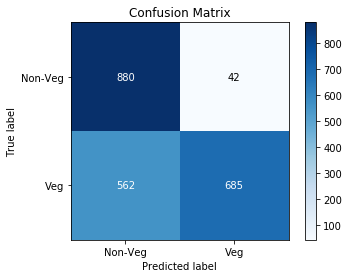

<Figure size 432x288 with 0 Axes>

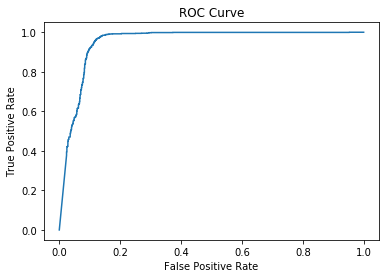

In [212]:
clf_gnb = GaussianNB()
reports(name = 'Gaussian Naive Bayes',classifier=clf_gnb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

Logistic Regression
   test_f1_macro  test_accuracy  test_roc_auc
0       0.939945       0.941700      0.965400
1       0.959461       0.960474      0.982534
2       0.941180       0.942688      0.967169
3       0.949422       0.950593      0.973690
4       0.960436       0.961462      0.982582
Test Data Results:
Test Accuracy:  0.9529737206085753
              precision    recall  f1-score   support

     Non-Veg       0.96      0.93      0.94       922
         Veg       0.95      0.97      0.96      1247

    accuracy                           0.95      2169
   macro avg       0.95      0.95      0.95      2169
weighted avg       0.95      0.95      0.95      2169

Sensitivity:  0.93058568329718
Specificity:  0.9695268644747393
MCC:  0.9037062721787029
__________________________________________________________________________________
ROC AUC 0.9737291408273565


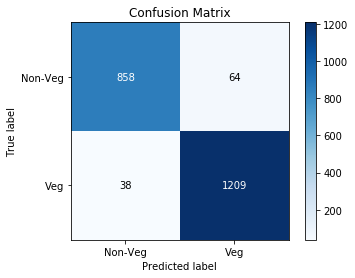

<Figure size 432x288 with 0 Axes>

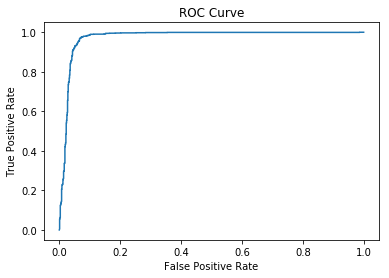

In [213]:
clf_logistic = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
reports(name = 'Logistic Regression',classifier=clf_logistic,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

Decision Tree
   test_f1_macro  test_accuracy  test_roc_auc
0       0.948329       0.949605      0.948083
1       0.950537       0.951581      0.952111
2       0.961463       0.962451      0.960712
3       0.960462       0.961462      0.959941
4       0.954521       0.955534      0.955453
Test Data Results:
Test Accuracy:  0.9626556016597511
              precision    recall  f1-score   support

     Non-Veg       0.96      0.95      0.96       922
         Veg       0.97      0.97      0.97      1247

    accuracy                           0.96      2169
   macro avg       0.96      0.96      0.96      2169
weighted avg       0.96      0.96      0.96      2169

Sensitivity:  0.9533622559652929
Specificity:  0.9695268644747393
MCC:  0.9235520598765442
__________________________________________________________________________________
ROC AUC 0.9629844816279245


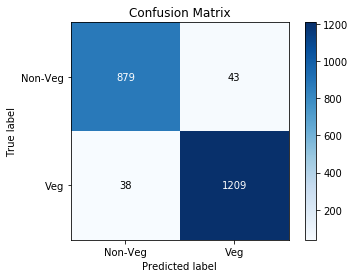

<Figure size 432x288 with 0 Axes>

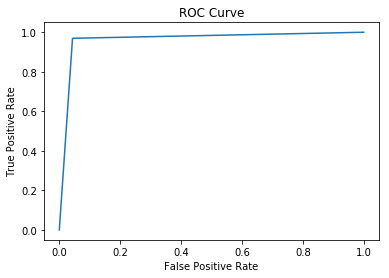

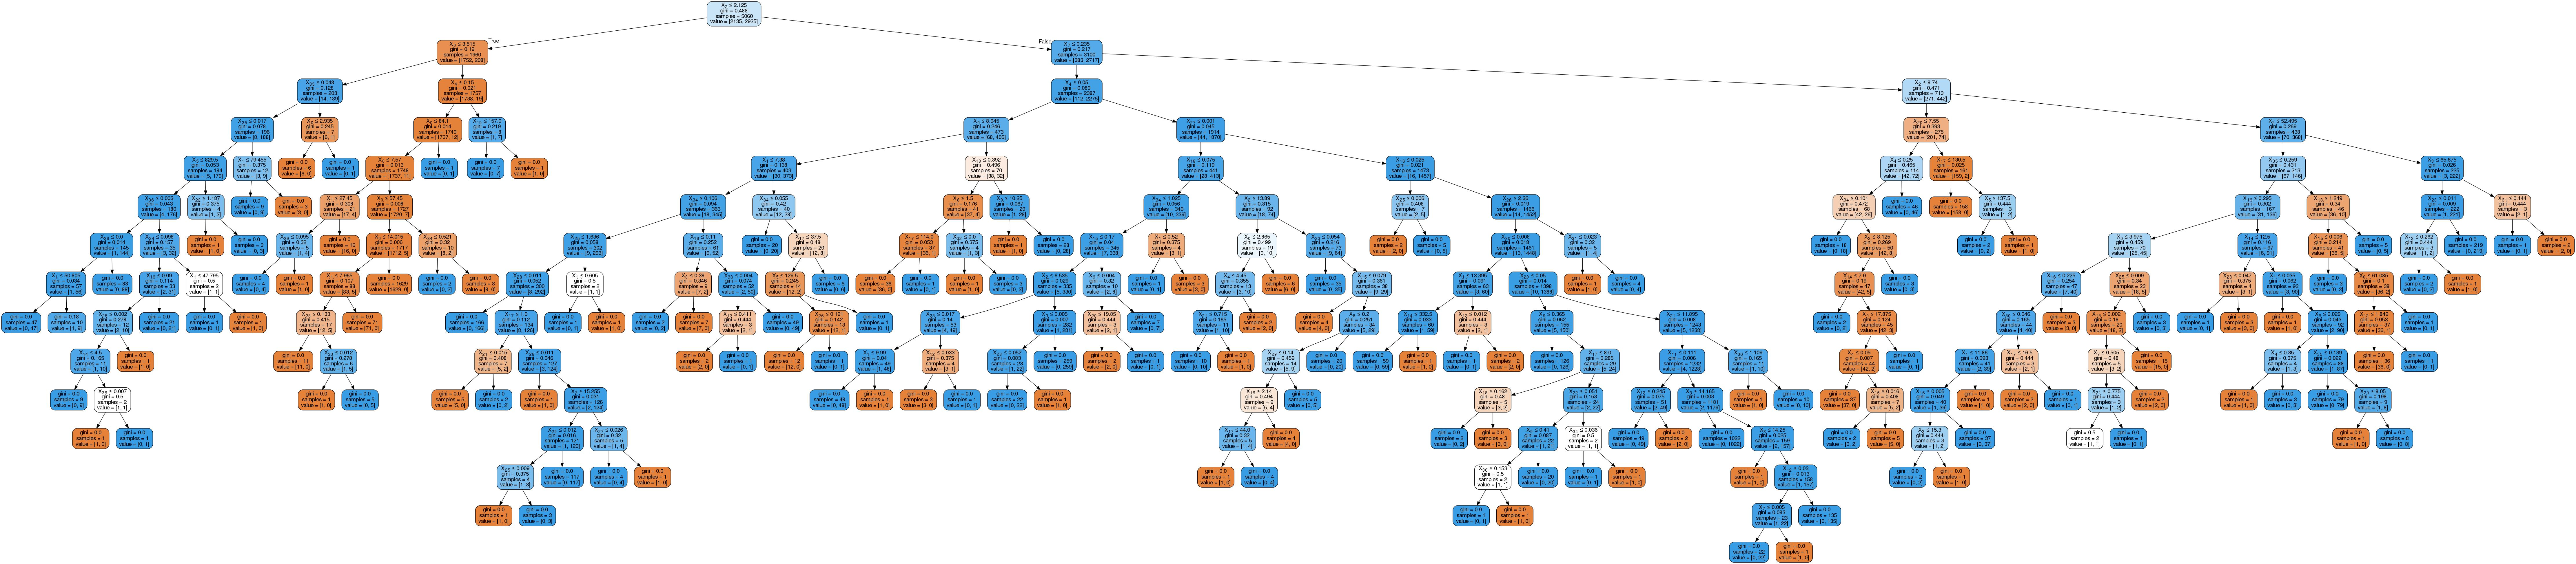

In [214]:
clf_decision_tree = DecisionTreeClassifier(random_state=0)

image = reports(name = 'Decision Tree',classifier=clf_decision_tree,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test,tree_flag=1)
dot_data = StringIO()
export_graphviz(image, out_file=dot_data,  
       filled=True, rounded=True,
       special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#         img= graph.create_jpeg()
Image(graph.create_jpeg())
#         plt.imshow(img)

Multinomial Naive Bayes
   test_f1_macro  test_accuracy  test_roc_auc
0       0.880407       0.882411      0.916602
1       0.911845       0.913043      0.958208
2       0.897243       0.899209      0.936314
3       0.890833       0.892292      0.944861
4       0.907838       0.909091      0.951102
Test Data Results:
Test Accuracy:  0.9022591055786077
              precision    recall  f1-score   support

     Non-Veg       0.87      0.91      0.89       922
         Veg       0.93      0.89      0.91      1247

    accuracy                           0.90      2169
   macro avg       0.90      0.90      0.90      2169
weighted avg       0.90      0.90      0.90      2169

Sensitivity:  0.9121475054229935
Specificity:  0.8949478748997595
MCC:  0.802312098266231
__________________________________________________________________________________
ROC AUC 0.9363809368079923


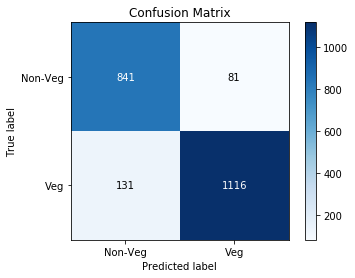

<Figure size 432x288 with 0 Axes>

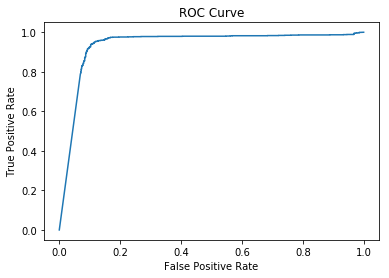

In [215]:
clf_mnb = MultinomialNB()
reports(name = 'Multinomial Naive Bayes',classifier=clf_mnb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

Random Forest
   test_f1_macro  test_accuracy  test_roc_auc
0       0.934025       0.936759      0.974855
1       0.948626       0.950593      0.982576
2       0.925962       0.928854      0.968372
3       0.926716       0.929842      0.976389
4       0.944380       0.946640      0.986501
Test Data Results:
Test Accuracy:  0.9372982941447672
              precision    recall  f1-score   support

     Non-Veg       0.98      0.87      0.92       922
         Veg       0.91      0.98      0.95      1247

    accuracy                           0.94      2169
   macro avg       0.94      0.93      0.93      2169
weighted avg       0.94      0.94      0.94      2169

Sensitivity:  0.8741865509761388
Specificity:  0.9839615076182838
MCC:  0.8736407471137744
__________________________________________________________________________________
ROC AUC 0.9799749333324056


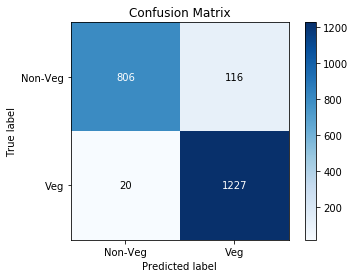

<Figure size 432x288 with 0 Axes>

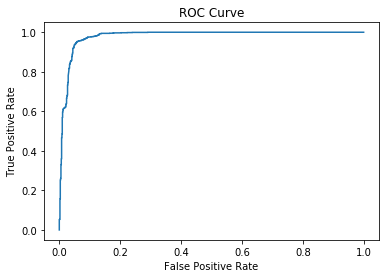

In [216]:
clf_randomforest = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
reports(name = 'Random Forest',classifier=clf_randomforest,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

XG Boost
   test_f1_macro  test_accuracy  test_roc_auc
0       0.966314       0.967391      0.996353
1       0.978668       0.979249      0.995724
2       0.972536       0.973320      0.995861
3       0.977660       0.978261      0.993194
4       0.980687       0.981225      0.997214
Test Data Results:
Test Accuracy:  0.9764868603042877
              precision    recall  f1-score   support

     Non-Veg       0.98      0.96      0.97       922
         Veg       0.97      0.99      0.98      1247

    accuracy                           0.98      2169
   macro avg       0.98      0.97      0.98      2169
weighted avg       0.98      0.98      0.98      2169

Sensitivity:  0.9609544468546638
Specificity:  0.9879711307137129
MCC:  0.9519383382036822
__________________________________________________________________________________
ROC AUC 0.9975272541300857


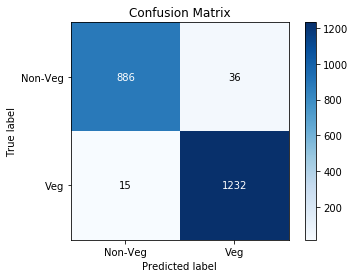

<Figure size 432x288 with 0 Axes>

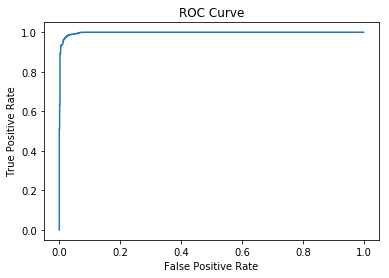

In [217]:
clf_xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=10,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
reports(name = 'XG Boost',classifier=clf_xgb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

Decision Tree Mod
   test_f1_macro  test_accuracy  test_roc_auc
0       0.950948       0.952569      0.960271
1       0.960357       0.961462      0.972045
2       0.954319       0.955534      0.966949
3       0.951952       0.953557      0.973518
4       0.965474       0.966403      0.984669
Test Data Results:
Test Accuracy:  0.9654218533886584
              precision    recall  f1-score   support

     Non-Veg       0.98      0.93      0.96       922
         Veg       0.95      0.99      0.97      1247

    accuracy                           0.97      2169
   macro avg       0.97      0.96      0.96      2169
weighted avg       0.97      0.97      0.97      2169

Sensitivity:  0.9349240780911063
Specificity:  0.9879711307137129
MCC:  0.9296511805042134
__________________________________________________________________________________
ROC AUC 0.9775013176960932


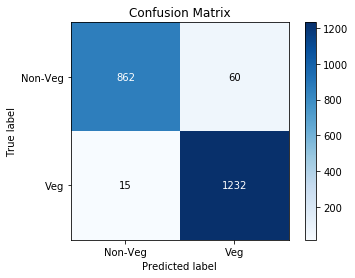

<Figure size 432x288 with 0 Axes>

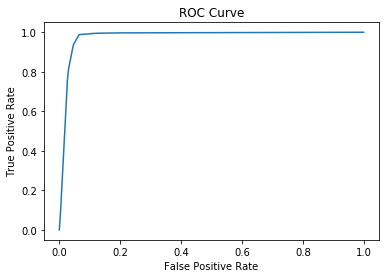

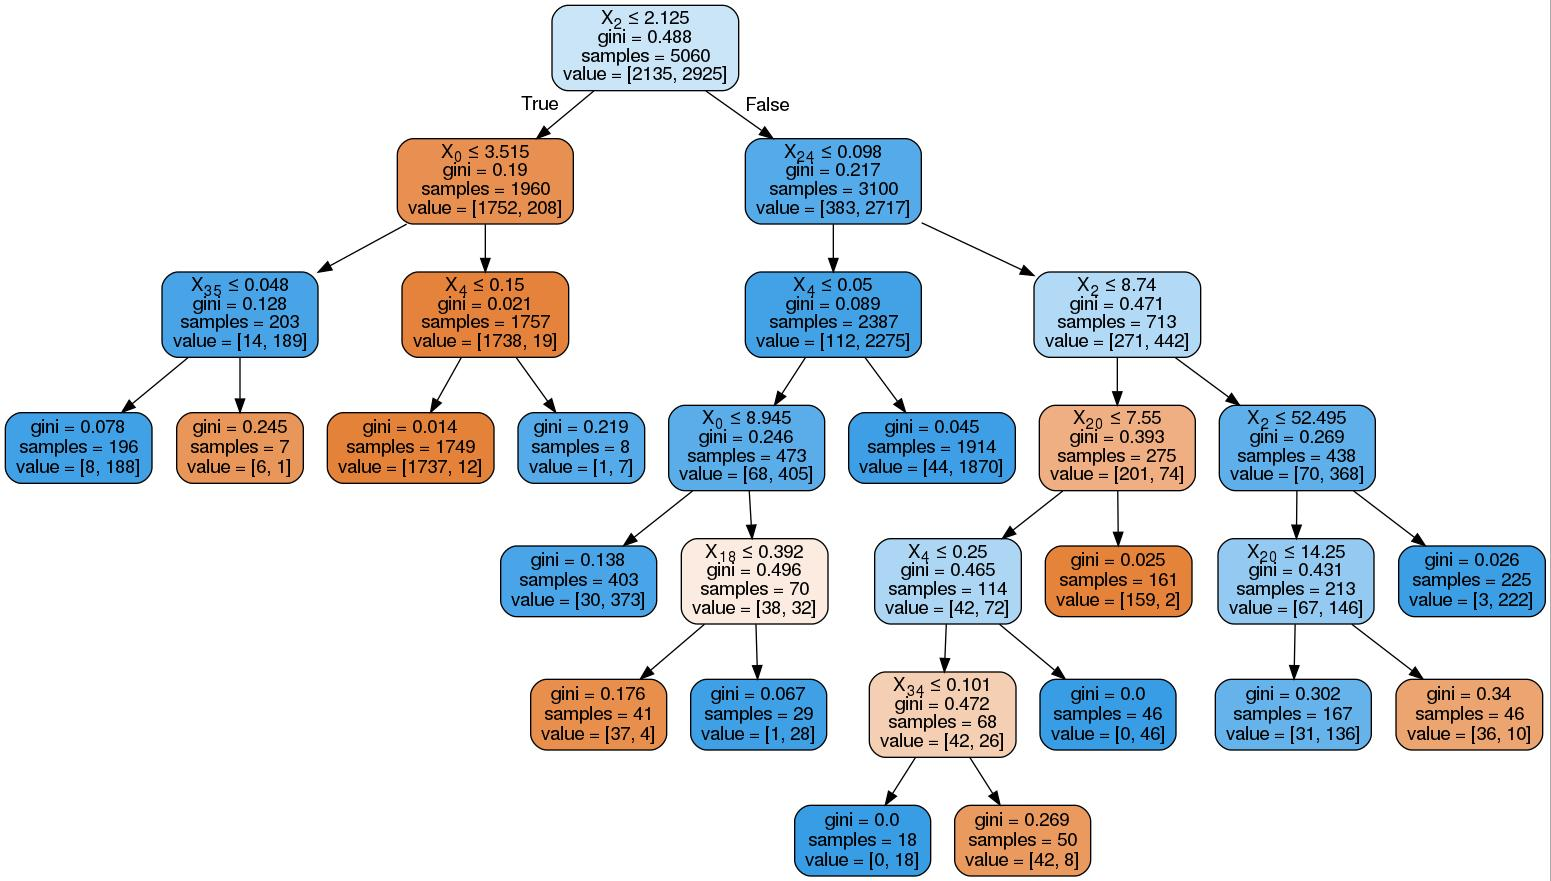

In [218]:
clf_decision_tree_mod = DecisionTreeClassifier(random_state=0,max_depth=10,max_leaf_nodes=15)

image = reports(name = 'Decision Tree Mod',classifier=clf_decision_tree_mod,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test,tree_flag=1)
dot_data = StringIO()
export_graphviz(image, out_file=dot_data,  
       filled=True, rounded=True,
       special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#         img= graph.create_jpeg()
Image(graph.create_jpeg())